# Banks Market Capitalization ETL Project

This notebook extracts data about the world's largest banks, transforms it into multiple currencies, stores it in CSV and SQLite formats, runs queries, and generates visualizations.

Author: Franck Echeverria Peñaloza


## Imports

Here we import libraries for:
- Data extraction (`requests`, `BeautifulSoup`)
- Data manipulation (`pandas`, `numpy`)
- Database operations (`sqlite3`)
- Visualization (`matplotlib`, `seaborn`)
- Logging and system utilities (`datetime`, `os`)

In [1]:
# Importing required libraries

import requests
import pandas as pd
from datetime import datetime
import sqlite3
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Define logging function to record ETL progress

In [2]:
log_file = 'Banks_by_Market_Capitalization_ETL.txt'

def log_progress(message):
    """
    Logs messages with timestamps to track ETL progress.

    Args:
        message (str): The message to log.
    """
    timestamp_format = '%Y/%m/%d %H:%M:%S'
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open(log_file, 'a') as log:
        log.write(timestamp + ': ' + message + '\n')


## Function to extract bank data from the given URL

In [3]:
def extract(url_name):
    """
    Extracts bank names and market capitalizations in USD from the target URL.

    Args:
        url_name (str): The webpage URL containing bank data.

    Returns:
        pd.DataFrame: Extracted bank data with columns 'Bank' and 'MC_USD_Billion'.
    """
    log_progress('Call extract() function')
    df = pd.DataFrame(columns=['Bank', 'MC_USD_Billion'])
    try:
        html_page = requests.get(url_name).text
        data = BeautifulSoup(html_page, 'html.parser')
        tables = data.find_all('tbody')
        rows = tables[0].find_all('tr')

        for row in rows:
            col = row.find_all('td')
            if len(col) != 0:
                a = col[1].find_all('a')
                data_dict = {
                    'Bank': a[1].contents[0],
                    'MC_USD_Billion': float(col[2].contents[0][:-1].replace(',', ''))
                }
                df1 = pd.DataFrame(data_dict, index=[0])
                df = pd.concat([df, df1], ignore_index=True)
        log_progress('Data extraction complete.')
    except Exception as e:
        log_progress(f"Extraction failed: {e}")
    return df


## Function to transform data by adding converted currency columns

In [4]:
def transform(data, exchange_file):
    """
    Transforms data by adding market capitalization columns in GBP, EUR, and INR.

    Args:
        data (pd.DataFrame): DataFrame with bank data.
        exchange_file (str): Path to exchange rate CSV file.

    Returns:
        pd.DataFrame: Transformed DataFrame with new currency columns.
    """
    log_progress('Call transform() function')
    try:
        exchange = pd.read_csv(exchange_file)
        exchange = exchange.set_index('Currency').to_dict()['Rate']
        data['MC_GBP_Billion'] = np.round(data['MC_USD_Billion'] * exchange['GBP'], 2)
        data['MC_EUR_Billion'] = np.round(data['MC_USD_Billion'] * exchange['EUR'], 2)
        data['MC_INR_Billion'] = np.round(data['MC_USD_Billion'] * exchange['INR'], 2)
        log_progress('Transformation complete.')
    except Exception as e:
        log_progress(f"Transformation failed: {e}")
    return data

## Function to save DataFrame to CSV

In [5]:
def load_to_csv(file_name, data):
    """
    Saves DataFrame to a CSV file.

    Args:
        file_name (str): Output file name.
        data (pd.DataFrame): DataFrame to save.
    """
    log_progress('Saving data to CSV.')
    data.to_csv(file_name, index=False)
    log_progress('Data saved to CSV.')

## Function to load DataFrame to SQLite database

In [6]:
def load_to_db(db_name, table_name, data):
    """
    Loads DataFrame to a SQLite database table.

    Args:
        db_name (str): SQLite database name.
        table_name (str): Table name to create/replace.
        data (pd.DataFrame): DataFrame to load.

    Returns:
        sqlite3.Connection: Connection object to the database.
    """
    log_progress('Initiating DB load.')
    conn = sqlite3.connect(db_name)
    data.to_sql(table_name, conn, if_exists='replace', index=False)
    log_progress('Data loaded to DB.')
    return conn

## Function to run SQL queries

In [7]:
def run_query(query, conn):
    """
    Runs an SQL query and returns the result.

    Args:
        query (str): SQL query string.
        conn (sqlite3.Connection): Database connection.

    Returns:
        pd.DataFrame: Query result.
    """
    return pd.read_sql(query, conn)

## Function to plot bar chart of top banks

In [8]:
# Function to plot bar chart of top banks

def plot_top_banks(data):
    """
    Generates a bar plot of banks by market cap in USD.

    Args:
        data (pd.DataFrame): DataFrame with bank data.
    """
    plt.figure(figsize=(10,6))
    sns.barplot(x='MC_USD_Billion', y='Bank', data=data.sort_values(by='MC_USD_Billion', ascending=False))
    plt.title('Top Banks by Market Cap (USD Billion)')
    plt.xlabel('Market Cap (USD Billion)')
    plt.ylabel('Bank')
    plt.tight_layout()
    plt.savefig('top_banks_usd.png')
    plt.show()

## Executing the ETL pipeline

C:\Users\Franck\AppData\Local\Temp\ipykernel_29232\3757298055.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df1], ignore_index=True)


                                      Bank  MC_GBP_Billion
0                           JPMorgan Chase          346.34
1                          Bank of America          185.22
2  Industrial and Commercial Bank of China          155.65
3               Agricultural Bank of China          128.54
4                                HDFC Bank          126.33
5                              Wells Fargo          124.70
6                        HSBC Holdings PLC          119.12
7                           Morgan Stanley          112.66
8                  China Construction Bank          111.86
9                            Bank of China          109.45
                                      Bank  MC_EUR_Billion
0                           JPMorgan Chase          402.62
1                          Bank of America          215.31
2  Industrial and Commercial Bank of China          180.94
3               Agricultural Bank of China          149.43
4                                HDFC Bank          146.

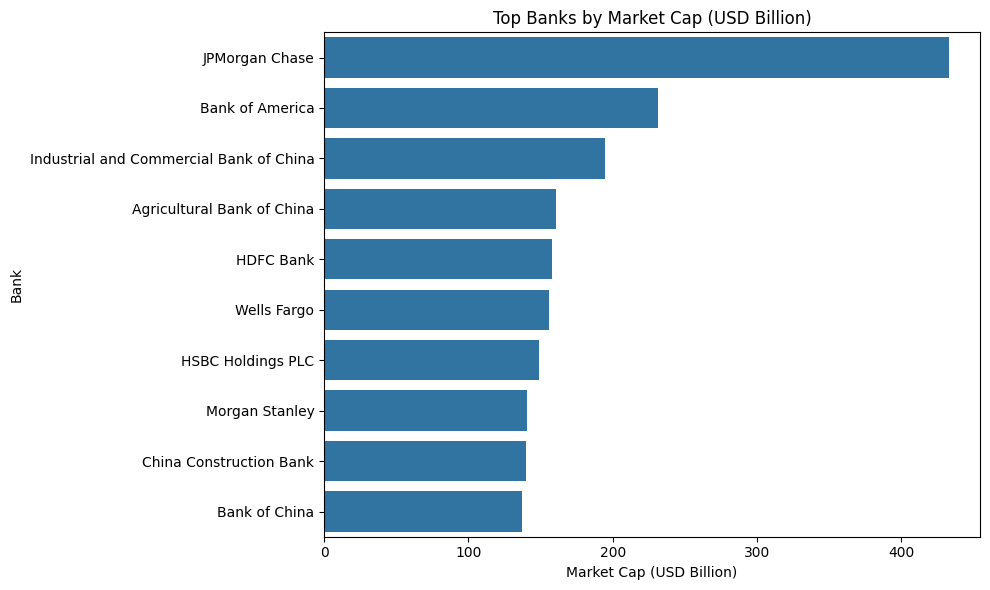

In [ ]:
# Define file paths and URLs
url_name = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'
db_name = 'Banks.db'
table_name = 'Largest_banks'
target_file = 'Banks_by_Market_Capitalization.csv'
exchange_file = 'exchange_rate.csv'

# Run ETL steps
log_progress('Starting ETL process')
data = extract(url_name)
data_transformed = transform(data, exchange_file)
load_to_csv(target_file, data_transformed)
conn = load_to_db(db_name, table_name, data_transformed)

# Run example queries
print(run_query(f"SELECT Bank, MC_GBP_Billion FROM {table_name}", conn))
print(run_query(f"SELECT Bank, MC_EUR_Billion FROM {table_name}", conn))
print(run_query(f"SELECT Bank, MC_INR_Billion FROM {table_name}", conn))

# Generate visualization
plot_top_banks(data_transformed)

# Closing DB connection
conn.close()

log_progress('ETL process complete.')


## Conclusion

In this notebook, I:

1. Extracted bank market capitalization data from Wikipedia.
2. Transformed it into GBP, EUR, and INR using provided exchange rates.
3. Loaded the results into a CSV and SQLite database.
4. Ran SQL queries for currency-specific outputs.
5. Created a bar plot visualization of market capitalizations.
